In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
import torch

import sqlite3
import pandas as pd

conn = sqlite3.connect('../data_collection/reddit_ed_0.6.0.sqlite3')

cursor = conn.cursor()

query = f"select * from subreddit_submission_metadata"

df = pd.read_sql_query(query,con=conn)
df["num_words"] = df["selftext"].apply(lambda x: len(x.split()))
word_length_cutoff = 20 # set a very low threshold
print(f"Number of short posts: {len(df[df['num_words'] < word_length_cutoff])}")
filtered_df = df[df["num_words"] >= word_length_cutoff]
print(f"Number of filtered posts (by word length): {len(filtered_df)}")
filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")
positive_flags = ["story", "progress"]
negative_flags = ["announcement", "educational", "research request", "resources", "advertise"]
uncertain_flags = ["question", "support", "advice"]
import re
positive_flag_regex = ".*(" + ")|(".join(positive_flags) + ").*"
negative_flag_regex = ".*(" + ")|(".join(negative_flags) + ").*"
uncertain_flag_regex = ".*(" + ")|(".join(uncertain_flags) + ").*"
filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
filtered_df["narrative_negative"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(negative_flag_regex, x) else 0)
filtered_df["narrative_uncertain"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(uncertain_flag_regex, x) else 0)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')



Number of short posts: 8940
Number of filtered posts (by word length): 15706


/var/folders/32/km91km0x2s98wl2f_rb4gb0r0000gn/T/ipykernel_24744/3094738657.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")
/var/folders/32/km91km0x2s98wl2f_rb4gb0r0000gn/T/ipykernel_24744/3094738657.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
/

In [12]:
def get_analysis_info(data: pd.DataFrame, type: str):
    column_name = f"narrative_{type}" 
    print(f"Number of {type}: {sum(data[column_name])} / {len(data)}")
    print(f"Values of flair flags: {data[data[column_name] == 1]['link_flair_text'].unique()}")
    return data[data[column_name] == 1][["title","link_flair_text", "selftext"]]

positive_df = get_analysis_info(filtered_df, "positive").reset_index(drop=True)

Number of positive: 159 / 15706
Values of flair flags: ['recovery story' 'story time' ':karma:personal story:karma:' 'my story'
 'progress']


In [13]:
positive_df

,title,link_flair_text,selftext
0,ED tip if you are trying to eat more,recovery story,Smoothies really helped me. You can put a bana...
1,Recovery Story,recovery story,\n\nI started getting insecure during lockdown...
2,This has been going on since 2006,recovery story,17 years of ED. It just seems like this will b...
3,so proud of myself,recovery story,I'm six days binge free! Today i didn't rexist...
4,It gets better,recovery story,I'm more than 2 years into recovery. I promise...
...,...,...,...
154,Life changing!!,progress,"I started Concerta for my ADHD, and taking it ..."
155,Lost five pounds!!,progress,"I know it’s super small, but omg!! I have hard..."
156,I resisted an urge today,progress,I told myself two days ago no more doordash be...
157,Finally Happy with My Life (Vyvanse),progress,"For context, I have always had a binge eating ..."


In [51]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [52]:
positive_df['selftext'][0]

'Smoothies really helped me. You can put a banana or two and a whole mango and some orange juice and blend it up. It’s like a drink but has lots of food in it. It might not work for everyone but it really helped me in my recovery'

In [53]:
model.encode(positive_df['selftext'][0])

array([ 1.30805103e-02,  1.42528592e-02, -2.11816244e-02, -2.28881072e-02,
        2.36960128e-02, -2.82726325e-02, -6.34592548e-02,  7.10942075e-02,
        1.15628084e-02, -2.28158496e-02,  6.21419447e-03, -2.58305315e-02,
        9.61081311e-03,  8.39987397e-02,  6.90345478e-04,  1.92633178e-02,
       -1.59767866e-02,  2.64626443e-02, -1.47007145e-02, -1.61937252e-02,
       -6.98123360e-03,  4.81561059e-03, -2.96965018e-02,  7.76736671e-03,
       -8.72887019e-03, -2.66245212e-02,  3.05515192e-02,  6.92518279e-02,
        3.50375590e-03, -1.08617276e-01, -2.33925339e-02,  1.94338933e-02,
       -1.45700341e-02, -1.59412362e-02,  1.05034621e-06,  2.49470351e-03,
       -4.17274050e-02, -5.43690212e-02, -4.37855236e-02, -5.06803058e-02,
        2.69062407e-02, -7.55837709e-02,  7.24581955e-03,  4.17195074e-03,
        3.22992541e-03, -2.98215952e-02,  2.57673785e-02,  6.22169822e-02,
       -2.74189655e-03,  2.23324876e-02, -1.94343068e-02, -7.81964585e-02,
        6.82197185e-03,  

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
import torch

def get_cls_token(text):
    
    with torch.no_grad():
        outputs = model.encode(text)
    return outputs


positive_df['sentence_bert_vector'] = positive_df['selftext'].apply(get_cls_token)





In [55]:
X = np.vstack(positive_df['sentence_bert_vector'].values)

In [56]:
positive_df.to_csv('mpnet_base_v2_narratives.csv')

2
3
4
5
6
7
8
9
10


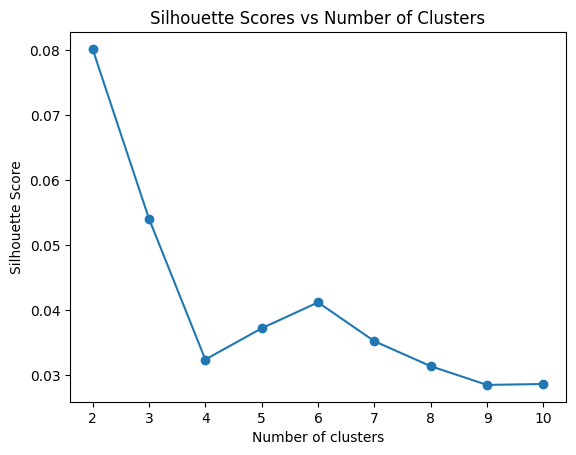

                                  title link_flair_text  \
0  ED tip if you are trying to eat more  recovery story   
1                        Recovery Story  recovery story   
2     This has been going on since 2006  recovery story   
3                    so proud of myself  recovery story   
4                        It gets better  recovery story   

                                            selftext  \
0  Smoothies really helped me. You can put a bana...   
1  \n\nI started getting insecure during lockdown...   
2  17 years of ED. It just seems like this will b...   
3  I'm six days binge free! Today i didn't rexist...   
4  I'm more than 2 years into recovery. I promise...   

                                sentence_bert_vector  stb_cluster  
0  [0.01308051, 0.014252859, -0.021181624, -0.022...            1  
1  [0.041634988, 0.08074127, 0.0070659444, -0.017...            1  
2  [0.0065379753, -0.004612305, -0.0061948495, -0...            0  
3  [0.009805465, 0.042033188, -0.007

In [57]:
cluster_range = range(2, 11)
silhouette_scores = []

for n_clusters in cluster_range:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs Number of Clusters')
plt.show()

optimal_n_clusters = cluster_range[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
positive_df['stb_cluster'] = kmeans.fit_predict(X)

print(positive_df.head())


In [58]:
from collections import Counter
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def top_keywords(df, cluster, n=10):
    words = []
    stop_words = set(stopwords.words('english'))
    for text in df[df['stb_cluster'] == cluster]['selftext']:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
        words.extend(filtered_tokens)
    word_counts = Counter(words)
    return word_counts.most_common(n)

for cluster in range(optimal_n_clusters):
    print(f"Top keywords in cluster {cluster}: {top_keywords(positive_df, cluster, 20)}")


Top keywords in cluster 0: [('’', 124), ('like', 57), ("n't", 38), ("'m", 28), ('really', 27), ('ed', 26), ('“', 25), ('”', 25), ('one', 24), ('time', 24), ('know', 23), ("'s", 23), ('people', 22), ('even', 21), ('would', 21), ('back', 20), ('feel', 20), ('think', 20), ('also', 19), ('get', 19)]
Top keywords in cluster 1: [('’', 465), ('like', 186), ("n't", 162), ('feel', 125), ('eating', 119), ('eat', 115), ('weight', 109), ("'m", 106), ('know', 101), ('time', 100), ("'s", 96), ('food', 91), ('really', 85), ('even', 85), ('get', 80), ('much', 78), ('still', 74), ('body', 73), ('day', 67), ('would', 67)]


In [59]:
positive_df[positive_df['stb_cluster'] == 1].shape

(95, 5)

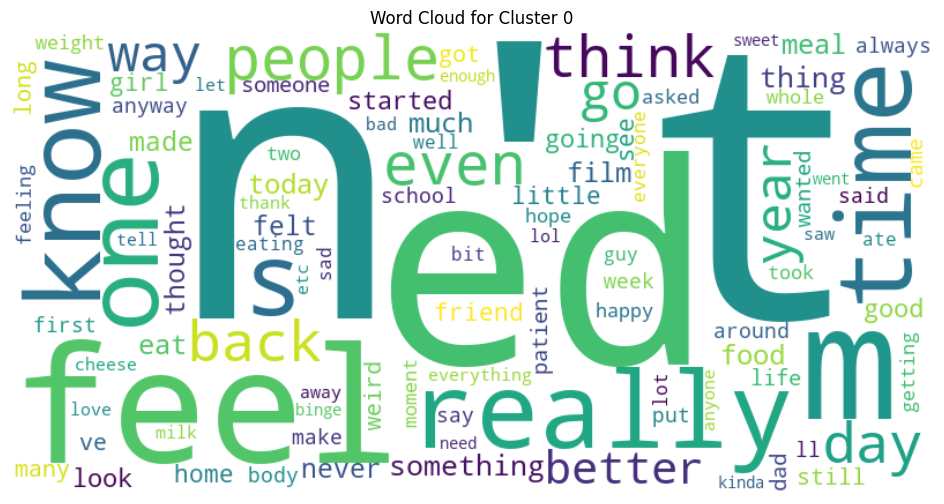

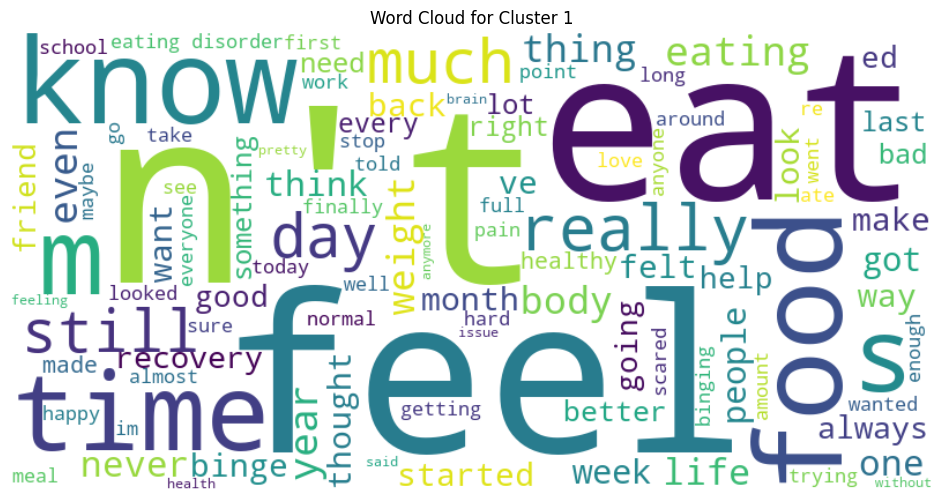

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def generate_wordcloud(df, cluster):
    stop_words = set(stopwords.words('english'))
    texts = df[df['stb_cluster'] == cluster]['selftext']
    filtered_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
        filtered_words.extend(filtered_tokens)
    filtered_text = ' '.join(filtered_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(filtered_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

for cluster in range(optimal_n_clusters):
    generate_wordcloud(positive_df, cluster)


In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(positive_df['selftext'])

def top_tfidf_features(cluster_texts, vectorizer, n=10):
    matrix = vectorizer.transform(cluster_texts)
    avg_tfidf = matrix.mean(axis=0).A1 
    sorted_indices = np.argsort(avg_tfidf)[::-1]
    return [(vectorizer.get_feature_names()[i], avg_tfidf[i]) for i in sorted_indices[:n]]

for cluster in range(optimal_n_clusters):
    cluster_texts = positive_df[positive_df['stb_cluster'] == cluster]['selftext']
    print(f"Top TF-IDF words in cluster {cluster}: {top_tfidf_features(cluster_texts, vectorizer)}")


Top TF-IDF words in cluster 0: [('like', 0.047755701439564945), ('just', 0.04530592685388768), ('ed', 0.03926673345119742), ('did', 0.035754037920775875), ('ve', 0.03425097733846667), ('don', 0.03282016142877411), ('today', 0.031230140347550117), ('time', 0.03115697031377127), ('really', 0.03078499627811674), ('think', 0.029045245908250993)]
Top TF-IDF words in cluster 1: [('like', 0.07216406300037313), ('eating', 0.06332073911251687), ('just', 0.0625929894558309), ('weight', 0.05777288591381082), ('eat', 0.05695678474271449), ('feel', 0.056551954031063584), ('ve', 0.05383393889601696), ('know', 0.050882090796253616), ('really', 0.045827161831744026), ('time', 0.04575476189792191)]


/Users/anthonycampbell/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
import pandas as pd
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def common_pos_tags(texts, pos, n=10):
    words = []
    for text in texts:
        tokens = word_tokenize(text)
        tagged_tokens = pos_tag(tokens)
        words.extend([word for word, tag in tagged_tokens if tag.startswith(pos) and word.lower() not in stop_words])
    word_counts = Counter(words)
    return word_counts.most_common(n)

for cluster in range(optimal_n_clusters):
    cluster_texts = positive_df[positive_df['stb_cluster'] == cluster]['selftext']
    
    print(f"Top adjectives in cluster {cluster}: {common_pos_tags(cluster_texts, 'JJ')}")
    print(f"Top verbs in cluster {cluster}: {common_pos_tags(cluster_texts, 'VB')}")
    print(f"Top nouns in cluster {cluster}: {common_pos_tags(cluster_texts, 'NN')}")
    print("\n")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonycampbell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top adjectives in cluster 0: [('’', 32), ('much', 13), ('good', 12), ('many', 11), ('better', 10), ('little', 10), ('“', 9), ('happy', 8), ('weird', 8), ('sad', 7)]
Top verbs in cluster 0: [('’', 78), ("'m", 28), ('know', 23), ("'s", 20), ('feel', 19), ('think', 18), ('go', 17), ('get', 17), ('wanted', 14), ('made', 14)]
Top nouns in cluster 0: [('time', 24), ('people', 22), ('”', 19), ('way', 17), ('something', 16), ('ED', 15), ('food', 15), ('film', 15), ('’', 14), ('day', 13)]


Top adjectives in cluster 1: [('’', 105), ('much', 58), ('good', 40), ('normal', 34), ('bad', 33), ('first', 32), ('healthy', 31), ('last', 29), ('full', 27), ('happy', 22)]
Top verbs in cluster 1: [('’', 299), ('feel', 119), ("'m", 106), ('eat', 99), ('know', 96), ("'s", 89), ('eating', 81), ('get', 78), ('got', 51), ('started', 49)]
Top nouns in cluster 1: [('time', 100), ('weight', 92), ('food', 86), ('body', 71), ('day', 64), ('’', 59), ('life', 57), ('years', 56), ('people', 51), ('way', 43)]


